In [1]:
import json
import os
import itertools

import rootpath
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
# matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import pycountry as pc
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import powerlaw

from lhledge import cfgLoader
from lhledge import lhlFilters
from lhledge import superrouters
from lhledge import loadGeographicData

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:

CYCLE = 8820
DATE = 20201002
# CYCLE = 4578
# DATE = 20160302
DOWNSAMPLING = 1

In [4]:
def ecdf(data, w=[]):
    """ Compute ECDF """
    if len(w) == 0:
        w = np.ones(len(data))
    #
    #     x = np.sort(data)
    idx = np.argsort(data).values
    #
    x = np.array(data)
    x = x[idx]
    w = w[idx]
    #
    n = x.size
    #     y = np.arange(1, n + 1) / n
    y = np.cumsum(w) / sum(w)
    return (np.squeeze(x), y)

In [5]:
def _get_max_subgraph(G):
    subg = nx.Graph()
    subg_size = 0
    subprahs = list(G.subgraph(c) for c in nx.connected_components(G))
    
    for subgraph in list(subprahs):
#         print(len(subgraph.nodes()))
        if  len(subgraph.nodes()) > subg_size:
            subg = subgraph
            subg_size = len(subg.nodes())

    return subg

In [6]:
# Change directory to run from the root dir of the project
path = rootpath.detect(pattern=".git")
os.chdir(path)

# load config file
cfg = cfgLoader.cfgLoader("config.yml")

# Load data

## Geographic data

In [7]:
def generate_graph(df):
    G = nx.from_pandas_edgelist(
        df.loc[df["diff_rtt"] > 57],
        "near_node_id",
        "far_node_id",
        edge_attr="diff_rtt"
    )

    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_node_asn"].values.astype(int),
            index=df["near_node_id"]
        ).to_dict(),
        'asn',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_node_asn"].values.astype(int),
            index=df["far_node_id"]
        ).to_dict(),
        'asn',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_cc"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'cc',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_cc"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'cc',
    )
    
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lat"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lat"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lat',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["near_side_lon"].values,
            index=df["near_node_id"]
        ).to_dict(),
        'lon',
    )
    nx.set_node_attributes(
        G,
        pd.Series(
            df["far_side_lon"].values,
            index=df["far_node_id"]
        ).to_dict(),
        'lon',
    )
    
    return G

In [8]:
cycle2year = {
    4577: 2016, 
    5423: 2017, 
    6447: 2018, 
    7616: 2019, 
    8821: 2020, 
    9644: 2021, 
    10020: 2022
} 

In [9]:
cycles = [4577, 5423, 6447, 7616, 8821, 9644, 10020]

In [10]:
a = pd.DataFrame()

for cycle in [4577, 5423, 6447, 7616, 8821, 9644, 10020]:
    
    df = pd.read_csv(f"data/processed/snapshots-longitudinal/{cycle}.csv.gz", compression="gzip")
    G = generate_graph(df)
    
    r = []
    
    for n1, n2, weight in G.edges(data=True):
    
        asn1 = G.nodes()[n1]["asn"]
        asn2 = G.nodes()[n2]["asn"]
        
        if asn1 > 0 and asn2 > 0:
            if asn1 > asn2:
                asn1, asn2 = asn2, asn1

            r.append((asn1, asn2, weight["diff_rtt"]))
    
    tmp = pd.DataFrame(r, columns=["asn1", "asn2", "rtt"])
    
    m = tmp.groupby(["asn1", "asn2"])["rtt"] \
        .median() \
        .reset_index()
    
    c = tmp.groupby(["asn1", "asn2"])["rtt"] \
        .count() \
        .reset_index()
    
    c = c.rename(columns = {'rtt':'cnt'})
    
    tmp = m.join(
        c.set_index(["asn1", "asn2"]),
        on=["asn1", "asn2"],
        how='left',
        lsuffix='_all',
        rsuffix='_mpls'
    )
    
    tmp["cycle"] = np.repeat(cycle, tmp.shape[0])
    
    a = pd.concat([a, tmp])


In [11]:
a.head()

,asn1,asn2,rtt,cnt,cycle
0,6,3549,152.610,1,4577
1,33,3549,148.081,1,4577
2,62,3549,120.181,3,4577
3,81,3549,97.798,2,4577
4,101,3549,161.593,1,4577


In [12]:
yoy = []
e2e = []

for idx, row in a.drop_duplicates(["asn1", "asn2"]).iterrows():
    
    tmp = a.loc[(a["asn1"] == row["asn1"]) & (a["asn2"] == row["asn2"])]
    
    for i in range(1, len(cycles)):
        x = tmp.loc[tmp["cycle"] == cycles[i - 1]]["rtt"]
        y = tmp.loc[tmp["cycle"] == cycles[i]]["rtt"]
        c0 = tmp.loc[tmp["cycle"] == cycles[i - 1]]["cnt"]
        c1 = tmp.loc[tmp["cycle"] == cycles[i]]["cnt"]
        
        if len(x) > 0 and len(y) > 0:
            yoy.append((cycles[i], row["asn1"], row["asn2"], y.values[0] - x.values[0], c1.values[0] - c0.values[0]))
        
    x = tmp.loc[tmp["cycle"] == cycles[0]]["rtt"]
    y = tmp.loc[tmp["cycle"] == cycles[-1]]["rtt"]
    c0 = tmp.loc[tmp["cycle"] == cycles[0]]["cnt"]
    c1 = tmp.loc[tmp["cycle"] == cycles[-1]]["cnt"]
    
    if len(x) > 0 and len(y) > 0:
        e2e.append((row["asn1"], row["asn2"], y.values[0] - x.values[0], c1.values[0] - c0.values[0]))

In [13]:
yoy = pd.DataFrame(yoy, columns=["cycle", "asn1", "asn2", "variation", "change_link_cnt"])
yoy.head()

,cycle,asn1,asn2,variation,change_link_cnt
0,5423,174.0,286.0,-8.1150,0
1,7616,174.0,1299.0,49.9650,0
2,8821,174.0,1299.0,7.6135,1
3,9644,174.0,1299.0,-31.3145,1
4,10020,174.0,1299.0,7.4305,-1


In [14]:
e2e = pd.DataFrame(e2e, columns=["asn1", "asn2", "variation", "change_link_cnt"])
e2e.head()

,asn1,asn2,variation,change_link_cnt
0,174.0,1299.0,19.0870,2
1,174.0,4538.0,-68.2655,-1
2,174.0,7713.0,7.6915,1
3,174.0,8452.0,2.7075,9
4,174.0,12956.0,21.3290,0


- [Negative] Destruction of LHLs
- [Negative] Creation of new LHLs but shorter than prexisting, shifting mean values towards lower values
- [Positive] Creation of new LHLs

In [15]:
x0 = a.loc[a["cycle"] == cycles[0]]
x1 = a.loc[a["cycle"] == cycles[-4]]


tmp = x0.join(
    x1.set_index(["asn1", "asn2"]),
    on=["asn1", "asn2"],
    how='inner',
    lsuffix='_i',
    rsuffix='_f'
)


In [16]:
tmp["cnt_diff"] = tmp["cnt_f"] - tmp["cnt_i"]

In [17]:
tmp

,asn1,asn2,rtt_i,cnt_i,cycle_i,rtt_f,cnt_f,cycle_f,cnt_diff
9,174,286,94.2140,1,4577,110.9550,1,7616,0
11,174,1299,82.2260,1,4577,117.5835,2,7616,1
12,174,3213,148.6180,1,4577,130.7360,1,7616,0
13,174,3257,121.6365,2,4577,62.6010,20,7616,18
14,174,3549,93.3830,3,4577,153.0845,2,7616,-1
...,...,...,...,...,...,...,...,...,...
2295,58511,58511,131.4780,3,4577,206.3070,5,7616,2
2296,59605,59605,83.7870,5,4577,93.1670,60,7616,55
2298,64049,64049,115.4000,3,4577,155.7440,9,7616,6
2303,200612,200612,126.5530,1,4577,111.6470,8,7616,7


Text(0.5, 0, 'mean RTT (2016)')

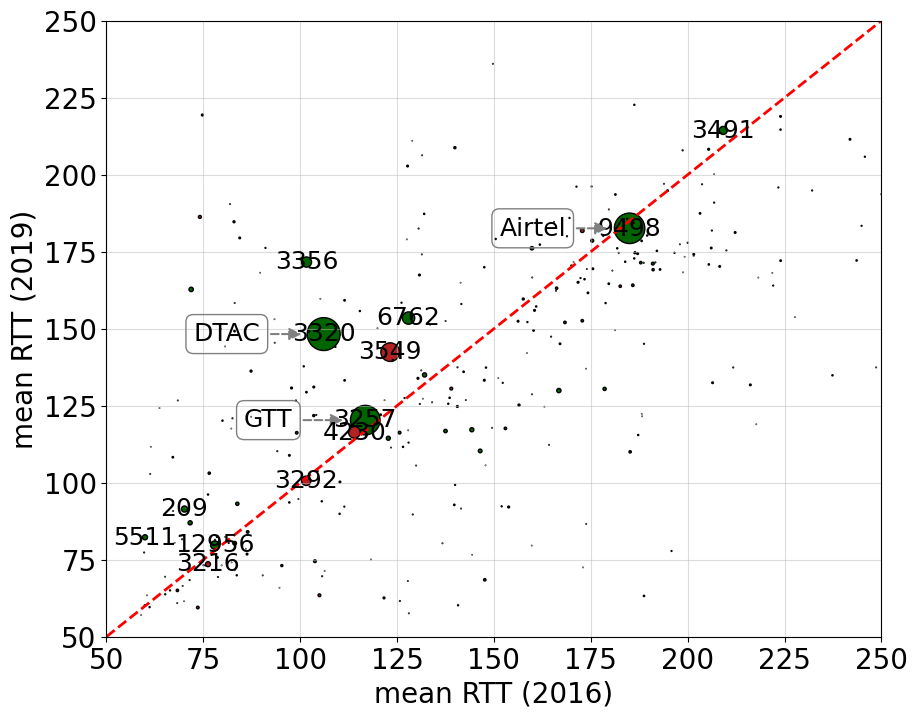

In [18]:
fig, ax = plt.subplots(1, figsize=(10, 8), sharey=True)

ax.yaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')
ax.xaxis.grid(True, linestyle='-', color='#bababa', alpha=0.5, which='both')


ax.scatter(
    tmp.loc[tmp["cnt_diff"] > 0]["rtt_i"],
    tmp.loc[tmp["cnt_diff"] > 0]["rtt_f"],
    s = np.abs(tmp.loc[tmp["cnt_diff"] > 0]["cnt_diff"]) / 10 ,
    color="darkgreen",
    edgecolor="k"
)

ax.scatter(
    tmp.loc[tmp["cnt_diff"] < 0]["rtt_i"],
    tmp.loc[tmp["cnt_diff"] < 0]["rtt_f"],
    s = np.abs(tmp.loc[tmp["cnt_diff"] < 0]["cnt_diff"]) / 10 ,
    color="firebrick",
    edgecolor="k"
)

ax.plot(
    [0, 250],
    [0, 250],
    lw=2,
    ls="--",
    color="red"
)

for idx, row in tmp.loc[tmp["cnt_diff"].abs() > 100].iterrows():

    ax.annotate(
        f'{int(row["asn1"])}',
        xy=(row["rtt_i"], row["rtt_f"],),
        ha="center",
        va="center",
        fontsize=18
    )
    
    if int(row["asn1"]) == 3320:
        label = "DTAC"
    elif int(row["asn1"]) == 9498:
        label = "Airtel"
    elif int(row["asn1"]) == 3257:
        label = "GTT"
    else:
        label = ""
    
    if len(label) > 0:
        ax.annotate(
            f'{label}',
            xy=(row["rtt_i"] - 5, row["rtt_f"],),
            xytext=(row["rtt_i"] - 25, row["rtt_f"],),
            ha="center",
            va="center",
            fontsize=18,
            bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round'),
            arrowprops=dict(arrowstyle= '-|>',
                             color='grey',
                             lw=1.5,
                             ls='--')
        )

ax.set_xlim(50, 250)
ax.set_ylim(50, 250)

FONTSIZE = 20

# ax.set_xscale('symlog')
# ax.set_yscale('log')

ax.tick_params(labelsize=FONTSIZE)
ax.set_ylabel('mean RTT (2019)', fontsize=FONTSIZE)
ax.set_xlabel('mean RTT (2016)', fontsize=FONTSIZE)


# ax.set_title("AS-level LH net", fontsize=35)
# fig.savefig("figures/lhnet/aslevel_length_variation_2016_2019.pdf")

In [19]:
tmp["rtt_gain"] = tmp["rtt_f"] - tmp["rtt_i"]

In [20]:
tmp.loc[tmp["cnt_diff"].abs() > 100]

,asn1,asn2,rtt_i,cnt_i,cycle_i,rtt_f,cnt_f,cycle_f,cnt_diff,rtt_gain
77,209,3320,70.1480,1,4577,91.4575,194,7616,193,21.3095
346,3216,3216,76.2215,132,4577,73.5540,5,7616,-127,-2.6675
354,3257,3257,116.8015,2766,4577,120.3225,7302,7616,4536,3.5210
455,3292,3292,101.5610,1290,4577,100.6270,830,7616,-460,-0.9340
469,3320,3320,106.0725,14,4577,148.2645,5632,7616,5618,42.1920
483,3356,3549,101.6290,31,4577,171.6510,575,7616,544,70.0220
497,3491,3491,209.1710,235,4577,214.3770,573,7616,338,5.2060
579,3549,3549,123.2355,2760,4577,142.3995,954,7616,-1806,19.1640
1373,4230,4230,114.0000,882,4577,116.3480,183,7616,-699,2.3480
1453,5511,5511,59.9670,7,4577,82.2830,143,7616,136,22.3160
